In [144]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial import chebyshev, legendre, polynomial
import xarray as xr
from scipy.signal import savgol_filter
import gpflow 
import tensorflow as tf
from AFL.agent import HscedGaussianProcess as HGP

In [128]:
netcdf_path = '/home/drs18/AFL-Spectroscopy-dev/230529_AL_manifest-P188-PS80_4D_AffProp_turbidityAdded.nc'
ds_AL = xr.load_dataset(netcdf_path)
ds_AL

<xarray.Dataset>
Dimensions:                      (sample: 88, q: 500, wavelength: 2048)
Coordinates:
  * q                            (q) float64 0.009814 0.01036 ... 0.2791 0.2796
  * wavelength                   (wavelength) float64 180.8 181.2 ... 867.9
Dimensions without coordinates: sample
Data variables: (12/24)
    fname                        (sample) object 'AL_P188-PS80_4D_AffProp_03c...
    SAS                          (sample, q) float64 81.26 79.44 ... 49.54 49.54
    label                        (sample) float64 -1.0 -1.0 -1.0 ... -1.0 -1.0
    validated                    (sample) float64 1.0 1.0 1.0 ... 1.0 1.0 1.0
    SAS_transmission             (sample) float64 0.8104 0.8119 ... 0.7945
    sample_uuid                  (sample) object 'fcbedf59-358d-4d78-8465-a2b...
    ...                           ...
    spec_error                   (sample, wavelength) float64 0.0 2.0 ... 2.0
    PS80                         (sample) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    mfrac_PS80                   (sample) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    mass_PS80                    (sample) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    sample_uuid_short            (sample) object '03c94ff0' ... 'fefe63be'
    turbidity                    (sample) float64 0.9765 0.975 ... 0.9862 0.9737
Attributes: (12/32)
    components:                        ['PS80', 'P188', 'benzyl_alcohol_solut...
    P188_range:                        [ 1 25]
    benzyl_alcohol_solute_range:       [ 0 15]
    phenol_solute_range:               [ 0 15]
    P188_npts:                         12
    benzyl_alcohol_solute_npts:        15
    ...                                ...
    SAS_savgol_pedestal:               1e-12
    SAS_savgol_npts:                   250
    SAS_savgol_window_length:          31
    SAS_savgol_polyorder:              2
    SAS_savgol_logx:                   1
    SAS_savgol_logy:                   1

In [134]:
chevy_coeff_fits = []
for sas_pattern in ds_AL.SAS:
    q = ds_AL.q[(ds_AL.q > 1e-2) & (ds_AL.q < 1e-1)].values
    I = sas_pattern[(ds_AL.q > 1e-2) & (ds_AL.q < 1e-1)].values
    I_stand = (I-np.mean(I))/np.std(I)

    
    chev_coeff = chebyshev.chebfit(x=q,y=I_stand,deg=20)
    # chev_coeff.convert(domain=(-1,1))
    # chevy_fit = chebyshev.chebval(c=chev_coeff,x=q)
    chevy_fit = chebyshev.chebval(q,chev_coeff)
    chevy_coeff_fits.append(chev_coeff)




    # fig,ax = plt.subplots(1,3,figsize=(16,4),constrained_layout=True)
    
    # for i in range(3):
    
        
    #     I_stand = savgol_filter(I_stand,window_length=(31),polyorder=2,deriv=i)
    #     ax[i].plot(q,I_stand,label='smoothed')
    
        # chev_coeff = chebyshev.chebfit(x=q,y=I_stand,deg=20)
        # # chev_coeff.convert(domain=(-1,1))
        # # chevy_fit = chebyshev.chebval(c=chev_coeff,x=q)
        # chevy_fit = chebyshev.chebval(q,chev_coeff)
    
    #     leg_coeff = legendre.legfit(x=q,y=I_stand,deg=20)
    #     # leg_coeff.convert(domain=(-1,1))
    #     # leg_fit = legendre.legval(c=leg_coeff,x=q)
    #     leg_fit = legendre.legval(q,leg_coeff)
    
    #     poly_coeff = polynomial.polyfit(x=q, y=I_stand, deg=20)
    #     # poly_coeff.convert(domain=(-1,1))
    #     # poly_fit = polynomial.polyval(c=poly_coeff,x=q)
    #     poly_fit = polynomial.polyval(q,poly_coeff)
        
    #     ax[i].plot(q, chevy_fit, label="chebychev fit")
    #     ax[i].plot(q, leg_fit, label='legendre fit')
    #     ax[i].plot(q,poly_fit, label='poly fit')
    #     # if i ==1:
    #     #     grad1 = np.gradient(leg_fit_static)
    #     #     ax[i].plot(q, grad1)
    #     # elif i ==2:
    #     #     grad2 = np.gradient(grad1)
    #     #     ax[i].plot(q, grad2)
    #     ax[i].set(
    #         xlabel="Q in $\AA$$^{-1}$",
    #         ylabel="intensity a.u.",
    #         xscale="log"   
    #     )
    #     ax[i].legend()
    

/home/drs18/miniconda3/envs/afl_agent/lib/python3.8/site-packages/numpy/polynomial/chebyshev.py:1671: RankWarning: The fit may be poorly conditioned
  return pu._fit(chebvander, x, y, deg, rcond, full, w)


In [205]:
Y = np.array([(i - np.mean(i))/np.std(i) for i in np.array(chevy_coeff_fits).T], dtype='float64')
X = np.array([
     ds_AL.benzyl_alcohol_solute/ds_AL.benzyl_alcohol_solute.max(),
     ds_AL.phenol_solute/ds_AL.phenol_solute.max(),
     ds_AL.P188/ds_AL.P188.max(),
     ds_AL.PS80/ds_AL.PS80.max()
             ], dtype='float64').T
# print(X.shape,Y.shape)
cheb_GPs = []
# Y = 
# for y in Y:
kernel = gpflow.kernels.Matern52(variance=0.5, lengthscales=1.0)
# y = np.expand_dims(y,axis=0)
print(X.shape,y.shape)
GPR = gpflow.models.GPR(
    # data=(X,y),
    data=(X,Y.T),
    kernel=kernel
)
    
optimizer = tf.optimizers.Adam(learning_rate=0.01)
for i in range(100):
    optimizer.minimize(GPR.training_loss_closure(compile=True), GPR.trainable_variables)
# cheb_GPs.append(GPR)

(88, 4) (1, 88)


In [209]:
21**4

194481

In [210]:
#dimensions in the X direction are BA solute mass and phenol solute mass. But have to be back converted 
#The GPR happens in standardized space that goes from 0-1
xx1,xx2,xx3,xx4  = np.meshgrid(
    np.linspace(0,1,21),
    np.linspace(0,1,21),
    np.linspace(0,1,21),
    np.linspace(0,1,21)
)
μ_predict, σ_predict = GPR.predict_y(np.array([i.ravel() for i in [xx1,xx2,xx3,xx4]]).T)
print(μ_predict.shape,σ_predict.shape)
#these are the interpolated chebychev coefficient values from the data.
#there needs to be some way to confirm that the scattering data is realistic from the predicted values
#One way would be to write an L2 norm metric to compare the optimized model fit with the experimental data
# for i in range(21):
#     fig, ax = plt.subplots(1,2,figsize=(12,4))
#     fig.suptitle(f"Coefficient {i+1}")
#     mm = ax[0].imshow(μ_predict.numpy().T[i].reshape(101,101),origin='lower',clim=(np.min(μ_predict),np.max(μ_predict)))
#     ax[0].set(
#         xlabel='benzyl alcohol',
#         ylabel='phenol',
#         title= 'model mean'
#     )
#     plt.colorbar(mm,ax=ax[0])
    
#     mv = ax[1].imshow(σ_predict.numpy().T[i].reshape(101,101),origin='lower',clim=(np.min(σ_predict),np.max(σ_predict)))
#     ax[1].set(
#         xlabel='benzyl alcohol',
#         ylabel='phenol',
#         title= 'model variance'
#     )
#     plt.colorbar(mv,ax=ax[1])
#     plt.show(fig)
#     plt.close(fig)


(194481, 21) (194481, 21)


In [191]:
def SpectralReconstruct(GP_model=None, coords=[[0,0,0],[1,2,3]]], polytype='chebyshev'):
    """
    Returns the simulated diffraction pattern given the GP model and a specified coordinate and polynomial type 
    """
    if coords.shape[1] != GP_model.data[1].shape()[1]:
        print("error! the coordinates requested to not match the model dimensions")

    coeffs = GP_model.predict_y(np.array(coords))
    
    if polytype == 'chebyshev':
        spectra = chebyshev.chebval(x=q, c=coeffs)
    return spectra

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,0.238252
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,1.5011
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.99584


In [220]:
test = chebyshev.chebval(x=q,c=[μ_predict[i] for i in [35,20001,49000,135000,190001]])
[μ_predict[i] for i in [35,20001,49000,135000,190001]]

[<tf.Tensor: shape=(21,), dtype=float64, numpy=
 array([ 0.0594967 ,  0.05909974, -0.05951483,  0.05964185, -0.05946743,
        -0.05937556,  0.05948668,  0.05863062, -0.05953305,  0.05959223,
        -0.05941953, -0.05945137,  0.05947002, -0.05970237,  0.05906596,
         0.05952543, -0.05942063,  0.05957454, -0.05933564,  0.05959155,
        -0.059231  ])>,
 <tf.Tensor: shape=(21,), dtype=float64, numpy=
 array([ 0.10639209,  0.1044965 , -0.10653332,  0.1070716 , -0.1061707 ,
        -0.10577918,  0.10631657,  0.10266678, -0.10667192,  0.10677231,
        -0.10584071, -0.10615483,  0.10620401, -0.10714229,  0.10371388,
         0.10643608, -0.10589005,  0.10656304, -0.10537803,  0.10654921,
        -0.10480753])>,
 <tf.Tensor: shape=(21,), dtype=float64, numpy=
 array([ 0.00685294,  0.00836769, -0.00671394,  0.00631391, -0.00706882,
        -0.00735986,  0.00692655,  0.00962882, -0.00657861,  0.00658376,
        -0.00738053, -0.00705282,  0.00703236, -0.00636014,  0.00928037,
     

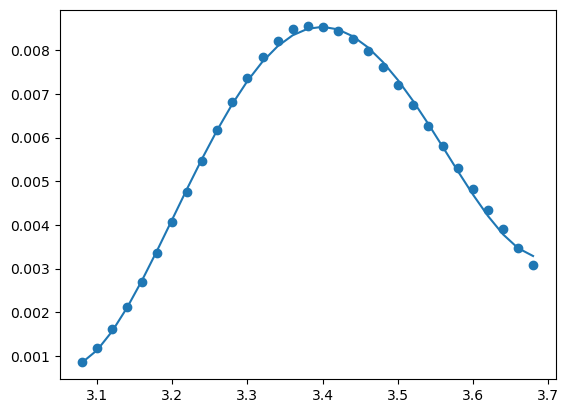

In [111]:
# data to fit
x =  [ 3.08,  3.1 ,  3.12,  3.14,  3.16,  3.18,  3.2 ,  3.22,  3.24,
    3.26,  3.28,  3.3 ,  3.32,  3.34,  3.36,  3.38,  3.4 ,  3.42,
    3.44,  3.46,  3.48,  3.5 ,  3.52,  3.54,  3.56,  3.58,  3.6 ,
    3.62,  3.64,  3.66,  3.68]
y =  [0.000857,  0.001182,  0.001619,  0.002113,  0.002702,  0.003351,
    0.004062,  0.004754,  0.00546 ,  0.006183,  0.006816,  0.007362,
    0.007844,  0.008207,  0.008474,  0.008541,  0.008539,  0.008445,
    0.008251,  0.007974,  0.00760f8,  0.007193,  0.006752,  0.006269,
    0.005799,  0.005302,  0.004822,  0.004339,  0.00391 ,  0.003481,
    0.003095]

poly_coeff = polynomial.polyfit(x=x, y=y, deg=4)
# poly_coeff = polynomial.polynomial.polyfit(x,y)
poly_fit = polynomial.polyval(x,poly_coeff)
plt.plot(x,poly_fit)
plt.scatter(x,y)